# Assignment 4

This is an basecode for assignment 4 of Artificial Intelligence class (CSCE-4613), Spring 2025


In [2]:
import torch
import torch.nn as nn
import torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Binary Network

## Define a binary network class


In [3]:
class BinaryNetwork(nn.Module):
  def __init__(self):
    # YOUR CODE HERE
    super(BinaryNetwork, self).__init__()
    self.layer1 = nn.Linear(2, 4)
    self.layer2 = nn.Linear(4, 1)

  def forward(self, x):
    # x has the size of (batch size x 2)
    # YOUR CODE HERE
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    return x

### Define data generator

In [4]:
def generate_data(operator = "AND"):
  assert operator in ["AND", "OR", "XOR", "NOR"], "%s operator is not valid" % operator
  data = []
  label = []
  for i in range(2):
    for j in range(2):
      data.append([i, j])
      if operator == "AND":
        label.append(i & j)
      elif operator == "OR":
        label.append(i | j)
      elif operator == "XOR":
        label.append(i ^ j)
      else:
        label.append(not (i | j))
  data = torch.as_tensor(data, dtype = torch.float32)
  label = torch.as_tensor(label, dtype = torch.float32)
  return data, label

### Define the training framework


Training AND operator
BinaryNetwork(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)
[100/1000]. Loss: 0.2910. Accuracy: 75.00
[200/1000]. Loss: 0.0755. Accuracy: 100.00
[300/1000]. Loss: 0.0317. Accuracy: 100.00
[400/1000]. Loss: 0.0188. Accuracy: 100.00
[500/1000]. Loss: 0.0130. Accuracy: 100.00
[600/1000]. Loss: 0.0099. Accuracy: 100.00
[700/1000]. Loss: 0.0079. Accuracy: 100.00
[800/1000]. Loss: 0.0065. Accuracy: 100.00
[900/1000]. Loss: 0.0056. Accuracy: 100.00
[1000/1000]. Loss: 0.0048. Accuracy: 100.00
Final Accuracy for AND: 100.00%

Training OR operator
BinaryNetwork(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)
[100/1000]. Loss: 0.2006. Accuracy: 100.00
[200/1000]. Loss: 0.0265. Accuracy: 100.00
[300/1000]. Loss: 0.0124. Accuracy: 100.00
[400/1000]. Loss: 0.0078. Accuracy: 100.00
[500/1000]. Loss: 0.0057. Accuracy: 100.00


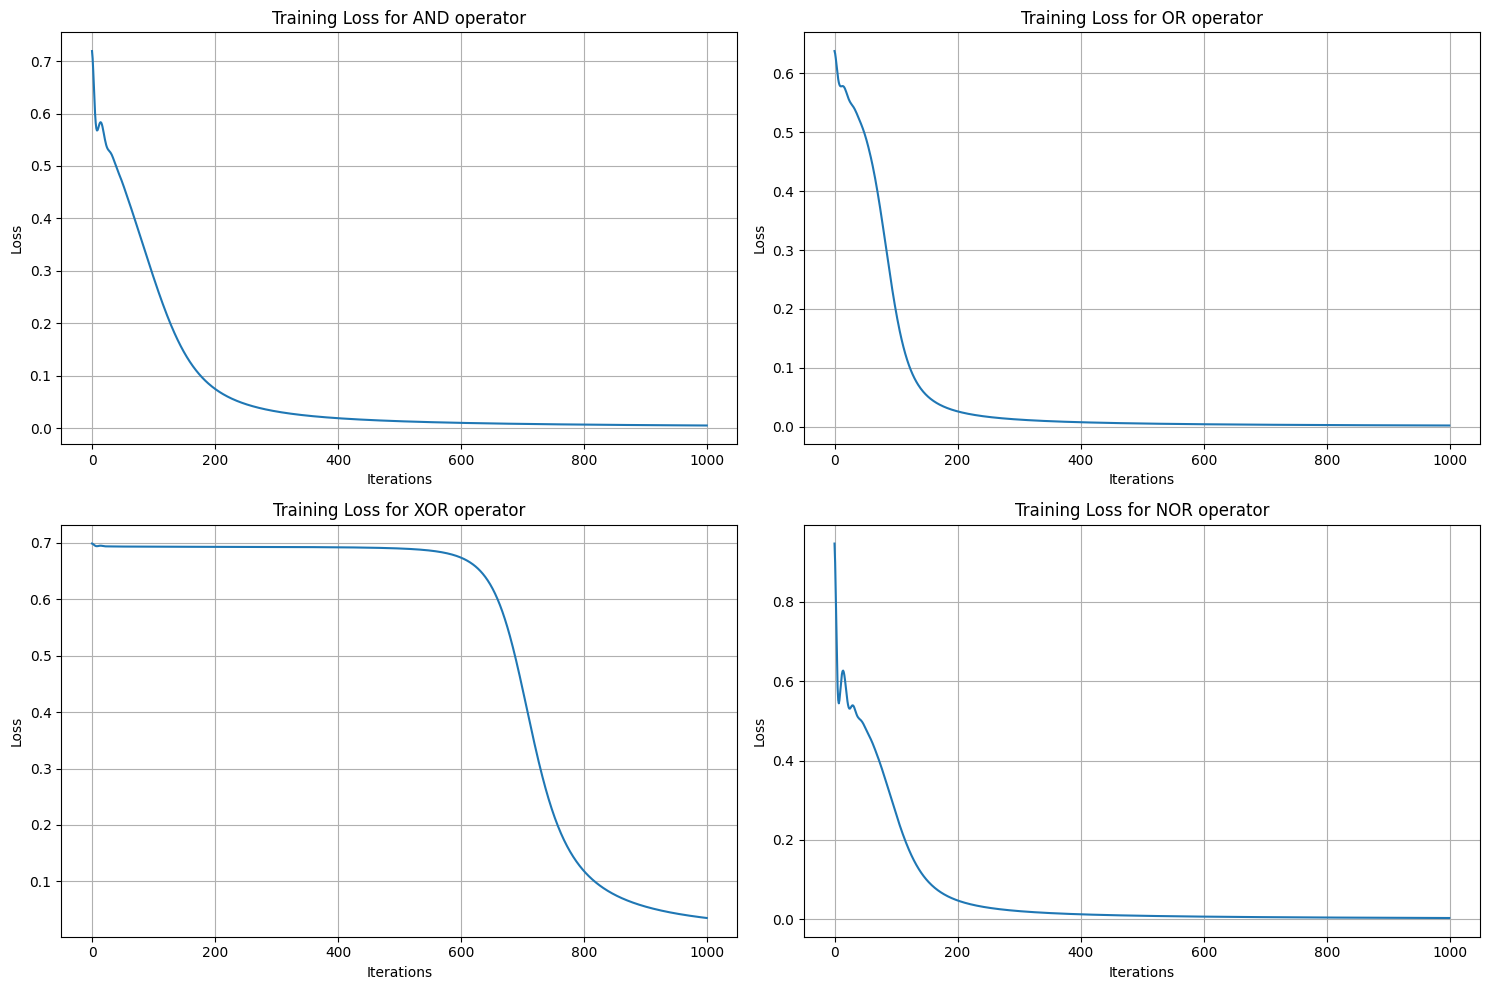


Summary of Final Accuracies:
AND: 100.00%
OR: 100.00%
XOR: 100.00%
NOR: 100.00%


In [5]:
import matplotlib.pyplot as plt

# List of operators to train
operators = ["AND", "OR", "XOR", "NOR"]

# Dictionary to store results for each operator
all_results = {}

# Create a figure for all loss plots
plt.figure(figsize=(15, 10))

for op_idx, operator in enumerate(operators):
    print(f"\n{'='*50}\nTraining {operator} operator\n{'='*50}")
    
    # Initialize model and optimizer
    model = BinaryNetwork()
    model.train()
    print(model)
    
    inputs, labels = generate_data(operator=operator)
    
    n_iters = 1000
    learning_rate = 0.1
    
    optim = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
    criterion = nn.BCELoss()
    losses = []  # To track progress
    
    for i in range(1, n_iters + 1):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        losses.append(loss.item())
        
        # Backpropagation and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # Calculate accuracy
        predicted = (outputs >= 0.5).float()
        accuracy = (predicted.view(-1) == labels).sum().item() / len(labels) * 100
        
        if i % 100 == 0:  # Print less frequently to keep output cleaner
            print("[%d/%d]. Loss: %0.4f. Accuracy: %0.2f" % (i, n_iters, loss, accuracy))
    
    # Evaluate final model
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        final_accuracy = (predicted.view(-1) == labels).sum().item() / len(labels) * 100
    
    print(f"Final Accuracy for {operator}: {final_accuracy:.2f}%")
    
    # Save model
    torch.save(model.state_dict(), f"{operator}_Network.pth")
    
    # Store results for this operator
    all_results[operator] = {
        'losses': losses,
        'final_accuracy': final_accuracy
    }
    
    # Add subplot for this operator
    plt.subplot(2, 2, op_idx+1)
    plt.plot(losses)
    plt.title(f'Training Loss for {operator} operator')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)

# Adjust layout and show the combined figure
plt.tight_layout()
plt.savefig('all_operators_loss.png')
plt.show()

# Print summary of all final accuracies
print("\nSummary of Final Accuracies:")
for op in operators:
    print(f"{op}: {all_results[op]['final_accuracy']:.2f}%")

## Digit Classification

### Define Digit Classification Network

In [6]:
class DigitNetwork(nn.Module):
  def __init__(self):
    super(DigitNetwork, self).__init__()
    # YOUR CODE HERE
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
    # x has the size of (batch size x 1 x height x height)
    # YOUR CODE HERE
    x = self.pool(torch.relu(self.conv1(x)))
    x = self.pool(torch.relu(self.conv2(x)))
    x = x.view(-1, 64 * 7 * 7)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x
  
  def count_parameters(self):
    """Count and return the number of parameters in each layer and total"""
    params_count = {}
    
    # Count parameters in each layer
    params_count['conv1'] = sum(p.numel() for p in self.conv1.parameters())
    params_count['conv2'] = sum(p.numel() for p in self.conv2.parameters())
    params_count['fc1'] = sum(p.numel() for p in self.fc1.parameters())
    params_count['fc2'] = sum(p.numel() for p in self.fc2.parameters())
    
    # Calculate total parameters
    params_count['total'] = sum(p.numel() for p in self.parameters())
    
    return params_count

### Define Data Generator

In [7]:
def create_data_generator(batch_size = 32, root = "data"):
  train_dataset = torchvision.datasets.MNIST(root = root,
                                             train = True,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
  test_dataset = torchvision.datasets.MNIST(root = root,
                                             train = False,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
  train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size = batch_size,
                                             shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size = batch_size,
                                             shuffle = False)
  return train_loader, test_loader

### Define the training framework

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 540kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.59MB/s]


DigitNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
Parameters per layer:
conv1: 320
conv2: 18496
fc1: 401536
fc2: 1290
total: 421642
Using CPU for training
Epoch [1/3]. Iter [1/938]. Loss: 2.31. Accuracy: 12.50
Epoch [1/3]. Iter [101/938]. Loss: 0.54. Accuracy: 44.21
Epoch [1/3]. Iter [201/938]. Loss: 0.22. Accuracy: 63.43
Epoch [1/3]. Iter [301/938]. Loss: 0.27. Accuracy: 71.98
Epoch [1/3]. Iter [401/938]. Loss: 0.28. Accuracy: 77.10
Epoch [1/3]. Iter [501/938]. Loss: 0.21. Accuracy: 80.51
Epoch [1/3]. Iter [601/938]. Loss: 0.15. Accuracy: 82.95
Epoch [1/3]. Iter [701/938]. Loss: 0.10. Accuracy: 84.75
Epoch [1/3]. Iter [

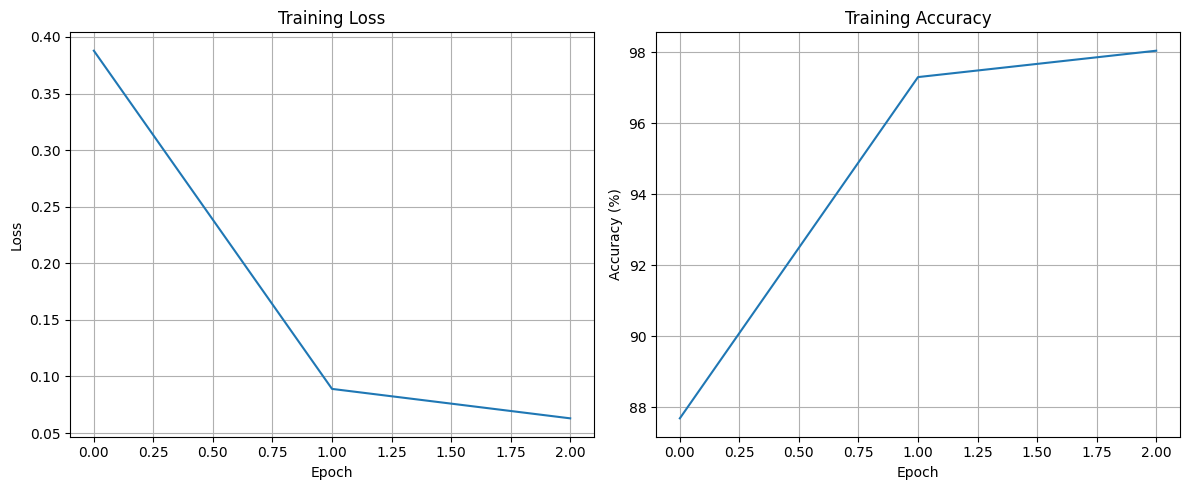

In [8]:
cuda = torch.cuda.is_available()
batch_size = 64 #32
train_loader, test_loader = create_data_generator(batch_size)
model = DigitNetwork()
print(model)

params = model.count_parameters()
print("Parameters per layer:")
for layer, count in params.items():
    print(f"{layer}: {count}")

if cuda:
  model.cuda()
  print("Using GPU for training")
else:
  print("Using CPU for training")

n_epochs = 3 #1
learning_rate = 0.01 #0.1
optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

losses = []
accuracies = []
batch_times = []
total_start_time = time.time()

model.train()
for epoch in range(1, n_epochs + 1):
  epoch_loss = 0.0
  correct = 0
  total = 0
  for idx, (images, labels) in enumerate(train_loader):
    # WRITE YOUR CODE TO COMPUTE OUTPUTS, LOSS, ACCURACY, AND OPTIMIZE MODEL
    # outptus = ???
    # loss = ???
    # accuracy = ???
    # optimize the model
    batch_start_time = time.time()
    if cuda:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    optim.zero_grad()
    loss.backward()
    optim.step()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    
    epoch_loss += loss.item()
    batch_end_time = time.time()
    batch_times.append(batch_end_time - batch_start_time)
    if idx % 100 == 0:
      print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(train_loader), loss, accuracy))

  epoch_avg_loss = epoch_loss / len(train_loader)
  losses.append(epoch_avg_loss)
  accuracies.append(accuracy)

  print(f"Epoch {epoch} completed. Average loss: {epoch_avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

total_training_time = time.time() - total_start_time
avg_batch_time = np.mean(batch_times)
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per batch: {avg_batch_time:.4f} seconds")

torch.save(model.state_dict(), "MNIST_Network.pth")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()


### Define the evaluation framework

Iter [1/10000]. Accuracy: 100.00
Iter [2001/10000]. Accuracy: 100.00
Iter [4001/10000]. Accuracy: 100.00
Iter [6001/10000]. Accuracy: 100.00
Iter [8001/10000]. Accuracy: 100.00
Final Accuracy: 98.86
Average inference time per sample: 0.00048 seconds


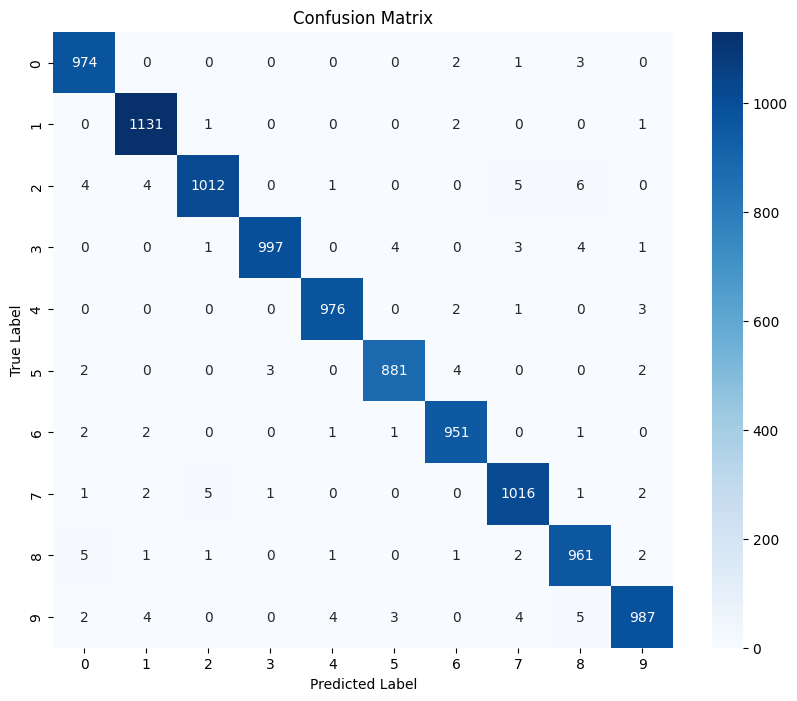

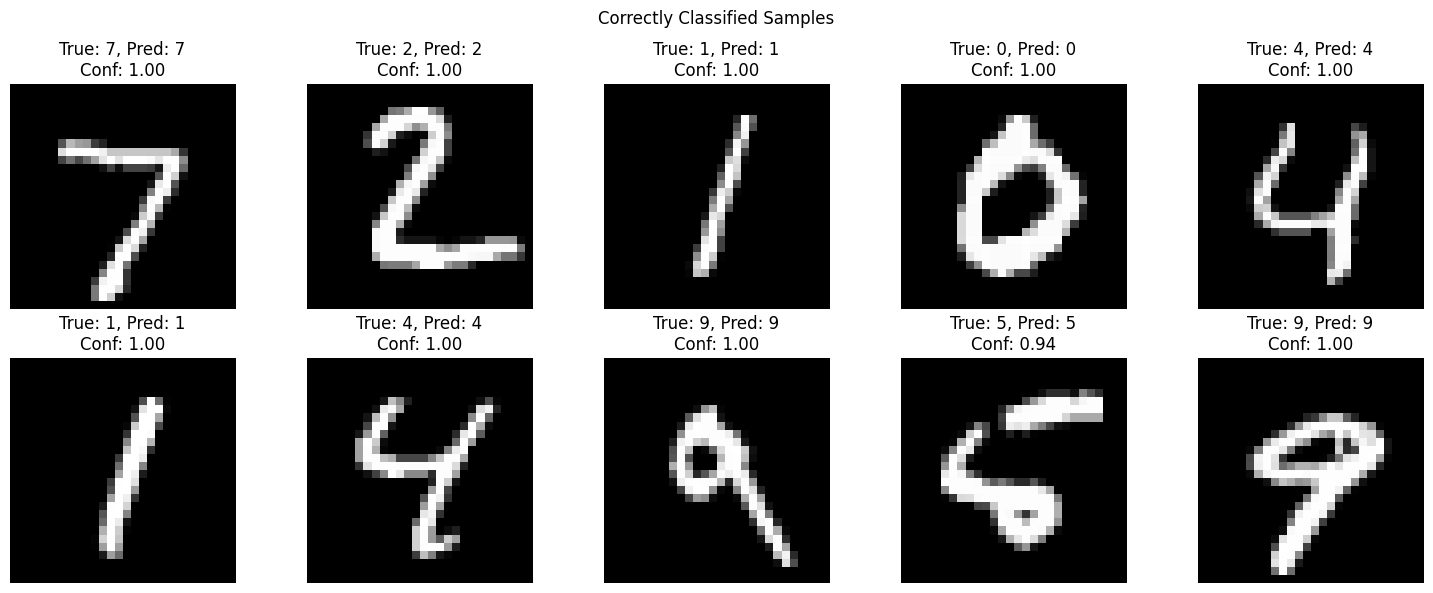

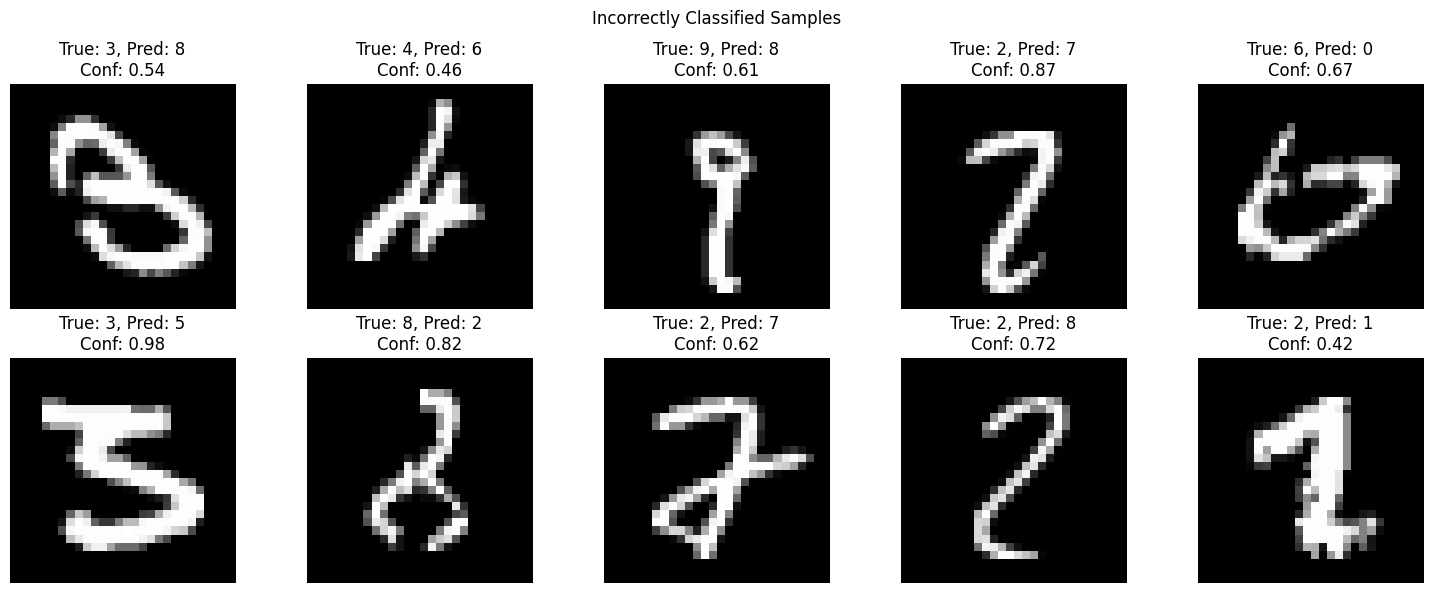

In [9]:
cuda = torch.cuda.is_available()
batch_size = 1
train_loader, test_loader = create_data_generator(batch_size)
model = DigitNetwork()
if cuda:
  model.cuda()
model.eval()
model.load_state_dict(torch.load("MNIST_Network.pth"))

all_preds = []
all_labels = []
inference_times = []
total_accuracy = 0.0

correct_samples = []
incorrect_samples = []
correct_confidences = []
incorrect_confidences = []

with torch.no_grad():
  for idx, (images, labels) in enumerate(test_loader):
  # WRITE YOUR CODE TO COMPUTE ACCURACY
  # accuracy = ???
    # accuracy = 0.0
    if cuda:
      images = images.cuda()
      labels = labels.cuda()

    start_time = time.time()
    outputs = model(images)
    end_time = time.time()
    inference_times.append(end_time - start_time)  
    probs = torch.nn.functional.softmax(outputs, dim=1)
    confidence, predicted = torch.max(probs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = 100 * correct / labels.size(0)
    all_preds.append(predicted.cpu().item())
    all_labels.append(labels.cpu().item())
    if correct == 1 and len(correct_samples) < 10:
      correct_samples.append((images.cpu().numpy(), labels.cpu().item(), predicted.cpu().item()))
      correct_confidences.append(confidence.cpu().item())
    elif correct == 0 and len(incorrect_samples) < 10:
      incorrect_samples.append((images.cpu().numpy(), labels.cpu().item(), predicted.cpu().item()))
      incorrect_confidences.append(confidence.cpu().item())
    
    total_accuracy += accuracy

    if idx % 2000 == 0:
      print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

avg_inference_time = np.mean(inference_times)
print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))
print("Average inference time per sample: %.5f seconds" % avg_inference_time)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()
if correct_samples:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ((img, label, pred), conf) in enumerate(zip(correct_samples, correct_confidences)):
        if i < 10:
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {label}, Pred: {pred}\nConf: {conf:.2f}')
            axes[i].axis('off')
    
    plt.suptitle('Correctly Classified Samples')
    plt.tight_layout()
    plt.savefig('correct_samples.png')
    plt.show()

# Visualize incorrectly classified samples
if incorrect_samples:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, ((img, label, pred), conf) in enumerate(zip(incorrect_samples, incorrect_confidences)):
        if i < 10:
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {label}, Pred: {pred}\nConf: {conf:.2f}')
            axes[i].axis('off')
    
    plt.suptitle('Incorrectly Classified Samples')
    plt.tight_layout()
    plt.savefig('incorrect_samples.png')
    plt.show()

## Backpropagation

### ReLU Example

In [10]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-defining-new-autograd-functions
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

#### Sigmoid Function


In [11]:
class MySigmoid(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        # input is a N x C tensor, N is the batch size, C is the dimension of input
        # ctx.save_for_backward(input)
        output = 1.0 / (1.0 + torch.exp(-input))
        ctx.save_for_backward(output)
        return output
        # YOUR CODE HERE
        # return output of sigmoid function

    @staticmethod
    def backward(ctx, grad_output):
        # input, = ctx.saved_tensors
        output, = ctx.saved_tensors
        grad_input = grad_output * output * (1 - output)
        return grad_input
        # YOUR CODE HERE
        # return grad_input

#### Fully Connected Layer

In [12]:
class MyLinearFunction(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input, weights, bias):
        # input is a N x C tensor, N is the batch size, C is the dimension of input
        # weights is a C x D tensor, C and D are the dimension out input and ouput
        # bias is D tensor
        ctx.save_for_backward(input, weights, bias)
        # YOUR CODE HERE
        # return output of linear function
        return torch.matmul(input, weights) + bias


    @staticmethod
    def backward(ctx, grad_output):
        input, weights, bias = ctx.saved_tensors
        grad_input = torch.matmul(grad_output, weights.t())
        grad_weights = torch.matmul(input.t(), grad_output)
        grad_bias = grad_output.sum(dim=0)

        # YOUR CODE HERE
        return grad_input, grad_weights, grad_bias

class MyLinearLayer(nn.Module):
  # You don't modify this layer
  def __init__(self, in_features = 2, out_features = 4):
    super(MyLinearLayer, self).__init__()
    self.weights = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.zeros(out_features))
    self.linear_fn = MyLinearFunction.apply

  def forward(self, input):
    return self.linear_fn(input, self.weights, self.bias)


#### Testing Your Implementation

In [13]:
class MyLinearNetwork(nn.Module):
  def __init__(self):
    super(MyLinearNetwork, self).__init__()
    self.linear_1 = MyLinearLayer(28 * 28, 128)
    self.sigmoid_fn = MySigmoid.apply
    self.linear_2 = MyLinearLayer(128, 10)
    self.softmax_fn = nn.Softmax(dim=1)

  def forward(self, x):
    size = x.size()
    x = x.reshape(size[0], -1) # Flatten images
    x = self.linear_1(x)
    x = self.sigmoid_fn(x)
    x = self.linear_2(x)
    if self.training == False:
      x = self.softmax_fn(x)
    return x

MyLinearNetwork(
  (linear_1): MyLinearLayer()
  (linear_2): MyLinearLayer()
  (softmax_fn): Softmax(dim=1)
)
Using CPU for training
Epoch [1/3]. Iter [1/1875]. Loss: 11.77. Accuracy: 15.62
Epoch [1/3]. Iter [101/1875]. Loss: 0.96. Accuracy: 62.22
Epoch [1/3]. Iter [201/1875]. Loss: 0.74. Accuracy: 71.28
Epoch [1/3]. Iter [301/1875]. Loss: 0.64. Accuracy: 75.57
Epoch [1/3]. Iter [401/1875]. Loss: 0.63. Accuracy: 77.67
Epoch [1/3]. Iter [501/1875]. Loss: 0.57. Accuracy: 79.20
Epoch [1/3]. Iter [601/1875]. Loss: 0.35. Accuracy: 80.45
Epoch [1/3]. Iter [701/1875]. Loss: 0.51. Accuracy: 81.46
Epoch [1/3]. Iter [801/1875]. Loss: 0.89. Accuracy: 82.26
Epoch [1/3]. Iter [901/1875]. Loss: 1.07. Accuracy: 82.99
Epoch [1/3]. Iter [1001/1875]. Loss: 0.13. Accuracy: 83.63
Epoch [1/3]. Iter [1101/1875]. Loss: 0.50. Accuracy: 84.26
Epoch [1/3]. Iter [1201/1875]. Loss: 0.41. Accuracy: 84.79
Epoch [1/3]. Iter [1301/1875]. Loss: 0.65. Accuracy: 85.23
Epoch [1/3]. Iter [1401/1875]. Loss: 0.11. Accuracy:

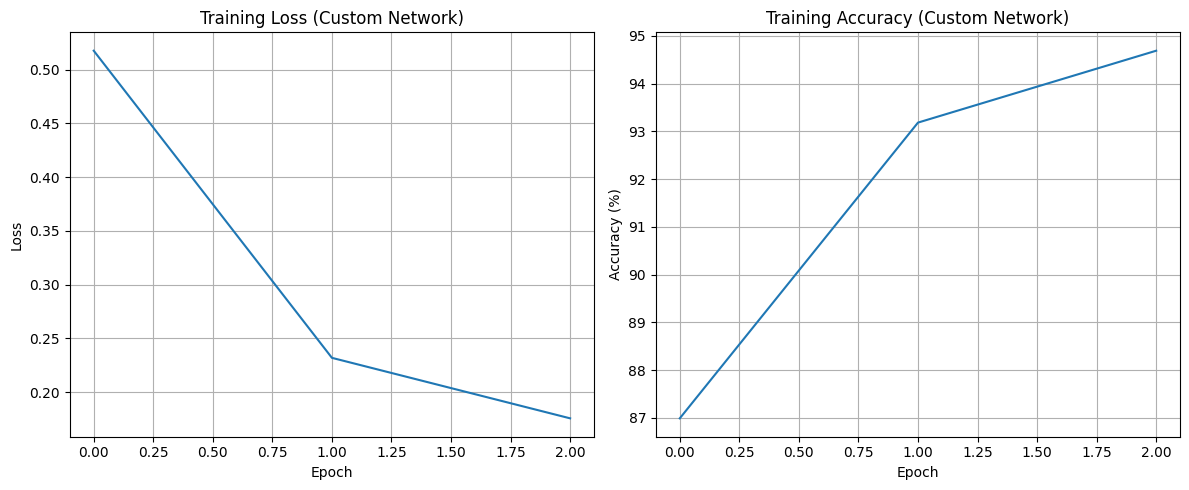

Iter [1/10000]. Accuracy: 100.00
Iter [2001/10000]. Accuracy: 100.00
Iter [4001/10000]. Accuracy: 0.00
Iter [6001/10000]. Accuracy: 0.00
Iter [8001/10000]. Accuracy: 100.00
Final Accuracy: 94.17
Average inference time per sample: 0.00020 seconds


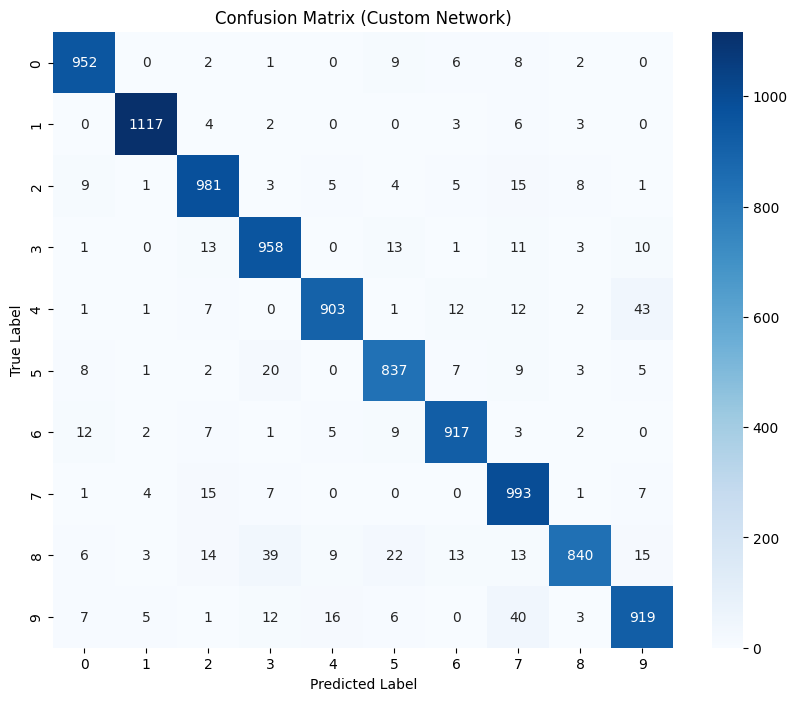

In [14]:
cuda = torch.cuda.is_available()
batch_size = 32
train_loader, test_loader = create_data_generator(batch_size)
model = MyLinearNetwork()
print(model)
if cuda:
  model.cuda()
  print("Using GPU for training")
else:
  print("Using CPU for training")
n_epochs = 3
learning_rate = 0.1
optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

losses = []
accuracies = []
batch_times = []
total_start_time = time.time()

model.train()
for epoch in range(1, n_epochs + 1):
  epoch_loss = 0.0
  correct = 0
  total = 0
  for idx, (images, labels) in enumerate(train_loader):
    # WRITE YOUR CODE TO COMPUTE OUTPUTS, LOSS, ACCURACY, AND OPTIMIZE MODEL
    # outptus = ???
    # loss = ???
    # accuracy = ???
    # optimize the model
    # loss = 0.0
    # accuracy = 0.0
    batch_start_time = time.time()
    if cuda:
      images = images.cuda()
      labels = labels.cuda()
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    epoch_loss += loss.item()
    batch_end_time = time.time()
    batch_times.append(batch_end_time - batch_start_time)

    if idx % 100 == 0:
      print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(train_loader), loss.item(), accuracy))
  epoch_avg_loss = epoch_loss / len(train_loader)
  losses.append(epoch_avg_loss)
  accuracies.append(accuracy)

  print(f"Epoch {epoch} completed. Average loss: {epoch_avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Report training time
total_training_time = time.time() - total_start_time
avg_batch_time = np.mean(batch_times)
print(f"Total training time: {total_training_time:.2f} seconds")
print(f"Average time per batch: {avg_batch_time:.4f} seconds")

# Plot training metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss (Custom Network)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy (Custom Network)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig('custom_network_metrics.png')
plt.show()

batch_size = 1  # For inference time measurement
train_loader, test_loader = create_data_generator(batch_size)
if cuda:
  model.cuda()
total_accuracy = 0.0
all_preds = []
all_labels = []
inference_times = []
model.eval()
with torch.no_grad():
  for idx, (images, labels) in enumerate(test_loader):
    # WRITE YOUR CODE TO COMPUTE ACCURACY
    # accuracy = ???
    # accuracy = 0.0
    if cuda:
          images = images.cuda()
          labels = labels.cuda()

    start_time = time.time()
    outputs = model(images)
    end_time = time.time()
    inference_times.append(end_time - start_time)

    _, predicted = torch.max(outputs.data, 1)
    accuracy = 100 * (predicted == labels).sum().item() / labels.size(0)

    all_preds.append(predicted.cpu().item())
    all_labels.append(labels.cpu().item())

    total_accuracy += accuracy

    if idx % 2000 == 0:
      print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

avg_inference_time = np.mean(inference_times)
print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))
print("Average inference time per sample: %.5f seconds" % avg_inference_time)
    
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Custom Network)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('custom_network_confusion_matrix.png')
plt.show()